# Prototyping Notebook

Prototyping for data loading, retrievals and evals



In [1]:

from dotenv import load_dotenv
import os
from uuid import uuid4

load_dotenv()

assert os.getenv("OPENAI_API_KEY"), "Missing OPENAI_API_KEY"
assert os.getenv("TAVILY_API_KEY"), "Missing TAVILY_API_KEY"
assert os.getenv("LANGCHAIN_API_KEY"), "Missing LANGCHAIN_API_KEY"
assert os.getenv("COHERE_API_KEY"), "Missing COHERE_API_KEY"

langsmith_api_key = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
langsmith_project_name = f"ADV_RETRIEVAL_CERT_{uuid4().hex[0:8]}"
os.environ["LANGCHAIN_PROJECT"] = langsmith_project_name
print(langsmith_project_name)

MODE = "CERT"

ADV_RETRIEVAL_CERT_f10949b4


In [2]:
import sys
import os
import pprint
from data_loader import DataLoader

pp = pprint.PrettyPrinter(width=80)  # wrap after 80 characters

# Use current working directory instead of __file__
notebook_dir = os.getcwd()

# Adjust path to point to base_folder (relative to where you're running the notebook)
base_folder = os.path.abspath(os.path.join(notebook_dir, ".."))  # or adjust accordingly

# Add base_folder to sys.path
if base_folder not in sys.path:
    sys.path.append(base_folder)

# Use the loader
data_loader = DataLoader("pd_blogs_filtered")
loaded_data = data_loader.load_data()

#pp.pprint(loaded_data[1])
pp.pprint(len(loaded_data))



81


# Create Vector Store

Create Vector Stores

In [3]:

import vector_stores
import importlib
importlib.reload(vector_stores)
from vector_stores import VectorStoresManager

vector_stores_manager = VectorStoresManager(
    MODE="baseline",
    loaded_data=loaded_data,
    chunk_config={"enabled": True, "params": {"chunk_size": 1500, "chunk_overlap": 250}},
    embeddings_model_name="text-embedding-3-small",
    chat_model="gpt-4.1-mini",
    collection_name="Rag Loaded Data Baseline"
)

vectorstore = vector_stores_manager.get_base_vectorstore()    


In [4]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
results =  retriever.invoke("What is the cure for kids whinning?")
for result in results:
    print("\n")
    pp.pprint(result)



Document(metadata={'source': '/home/jsmejia/the_ai_eng_bootcamp/code/aim_certification_challenge/data/pd_blogs_filtered/data_toddlers_1p5-3/015_The Cure for Whining.txt', '_id': 'd451238c8c044784939999147a30a4d8', '_collection_name': 'Rag Loaded Data Baseline'}, page_content='The Cure for Whining - Any parent who has ever had a toddler or a preschooler knows that whining is common at those ages -- and can drive any parent crazy. Parents are usually advised to tell their kids to ask in a "nice" voice, because they can\'t hear the whiny voice. But whining is a symptom of a deeper issue. So if you want to eliminate whining, you have to address what\'s underneath. If your child\'s whining is driving you crazy, here are six parent-proven secrets to stop the whining. Which secret you use depends on why your child is whining. 1. Whining because he doesn\'t have the internal resources to cope with what\'s being asked of him. When humans feel overwhelmed, they get whiny. As a toddler, he woul

In [5]:
retrievers_config = {
    "base": {
        "vectorstore": vector_stores_manager.get_base_vectorstore()
    },
    "parent_document": {
        "vectorstore": vector_stores_manager.get_parent_document_vectorstore(),
        "in_memory_store": vector_stores_manager.get_in_memory_store(),
        "child_splitter": vector_stores_manager.get_child_splitter()
    }
}

# Create All chain retrievers and wrappers

In [8]:
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset import TestsetGenerator
from ragas import EvaluationDataset
from ragas import evaluate as evaluate_ragas, RunConfig
from ragas.metrics import (
    LLMContextPrecisionWithReference,
    LLMContextRecall,
    ContextEntityRecall,
    Faithfulness,
    ResponseRelevancy
    )
from langsmith.evaluation import LangChainStringEvaluator, evaluate as evaluate_langsmith
from langsmith import Client as ClientLangSmith
import numpy as np
from retrievers import get_retrieval_chains_and_wrappers_for_evals
import pickle
import prompts
import importlib
importlib.reload(prompts)
from prompts import get_rag_prompt

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
chat_model = ChatOpenAI(model="gpt-4.1-mini")
rag_prompt = get_rag_prompt()

chains, wrappers = get_retrieval_chains_and_wrappers_for_evals(
    retrievers_config, 
    loaded_data, 
    rag_prompt, 
    chat_model, 
    MODE
)

# Create Eval Golden Dataset

In [9]:
from pathlib import Path

current_dir = os.getcwd()

file_path = Path("eval_golden_dataset.pkl")

if file_path.exists():
    print("File exists.")

    with open(f"eval_golden_dataset.pkl", "rb") as f:
        golden_dataset = pickle.load(f)

else:
    print("File does not exist.")

    generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1"))
    generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

    generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
    golden_dataset = generator.generate_with_langchain_docs(loaded_data, testset_size=50)

    # View the dataset
    golden_dataset.to_pandas()

    # Save to file
    with open(f"eval_golden_dataset.pkl", "wb") as f:
        pickle.dump(golden_dataset, f)

File does not exist.


Applying HeadlinesExtractor:   0%|          | 0/77 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/81 [00:00<?, ?it/s]

unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node


Applying SummaryExtractor:   0%|          | 0/88 [00:00<?, ?it/s]

Property 'summary' already exists in node 'd610c5'. Skipping!
Property 'summary' already exists in node '1873ff'. Skipping!
Property 'summary' already exists in node '250a18'. Skipping!
Property 'summary' already exists in node '4ea4ac'. Skipping!
Property 'summary' already exists in node 'ecc364'. Skipping!
Property 'summary' already exists in node '5064ec'. Skipping!
Property 'summary' already exists in node '1bf3ea'. Skipping!
Property 'summary' already exists in node 'b977d7'. Skipping!
Property 'summary' already exists in node 'ae5303'. Skipping!
Property 'summary' already exists in node 'c17257'. Skipping!
Property 'summary' already exists in node '0d8a1a'. Skipping!


Applying CustomNodeFilter:   0%|          | 0/179 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/436 [00:00<?, ?it/s]

Property 'summary_embedding' already exists in node 'd610c5'. Skipping!
Property 'summary_embedding' already exists in node '1873ff'. Skipping!
Property 'summary_embedding' already exists in node '250a18'. Skipping!
Property 'summary_embedding' already exists in node '5064ec'. Skipping!
Property 'summary_embedding' already exists in node '1bf3ea'. Skipping!
Property 'summary_embedding' already exists in node 'ecc364'. Skipping!
Property 'summary_embedding' already exists in node 'b977d7'. Skipping!
Property 'summary_embedding' already exists in node '4ea4ac'. Skipping!
Property 'summary_embedding' already exists in node 'ae5303'. Skipping!
Property 'summary_embedding' already exists in node '0d8a1a'. Skipping!
Property 'summary_embedding' already exists in node 'c17257'. Skipping!


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/51 [00:00<?, ?it/s]

# Evaluations

In [10]:

import copy
import pickle
import os

skip_evaluation = []

eval_full_results = {}
eval_summary_results = {}
eval_langsmith_raw_results = {}
eval_langsmith_summary_results = {}

for chain_name in chains.keys():
    print(f"\n=== Evaluating {chain_name} with RAGAS ===")

    if chain_name in skip_evaluation:
        print(f"Skipping {chain_name} because it is in skip_evaluation list. and already has been evaluated")
        continue

    # Prepare dataset for this chain
    golden_dataset_active_copy = copy.deepcopy(golden_dataset)

    print(f"data type dataset: {type(golden_dataset_active_copy)}")

    # Generate responses for evaluation
    for test_row in golden_dataset_active_copy:
        response = wrappers[chain_name](test_row.eval_sample.user_input)
        test_row.eval_sample.response = response["response"].content
        test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

    evaluation_active_dataset = EvaluationDataset.from_pandas(golden_dataset_active_copy.to_pandas())
    evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini"))

    custom_run_config = RunConfig(timeout=360)

    # Run evaluation using only RETRIEVAL metrics
    print("Running RAGAS evaluation...")
    eval_result_active = evaluate_ragas(
        dataset=evaluation_active_dataset,
        metrics=[LLMContextPrecisionWithReference(), LLMContextRecall(), ContextEntityRecall(), Faithfulness(), ResponseRelevancy()],
        llm=evaluator_llm,
        run_config=custom_run_config
    )

    eval_full_results[chain_name] = eval_result_active

    # Convert to DataFrames and compute statistics
    df_eval_result_active = eval_result_active.to_pandas()
    eval_result_active_means = df_eval_result_active.mean(numeric_only=True)
    eval_result_active_stds = df_eval_result_active.std(numeric_only=True)

    eval_summary_results[chain_name] = {
        "means": eval_result_active_means,
        "stds": eval_result_active_stds
    }
    
    print(f"RAGAS Results for {chain_name}:")
    print(eval_result_active_means)
    print(eval_result_active_stds)

    # save results to pickle in case of errors or crashes
    pickle_dict_active_ragas_results = { 
        "raw_results": eval_result_active, 
        "summary_results": eval_summary_results[chain_name] }

    # Save to file
    with open(f"eval_ragas_results_for_{chain_name}.pkl", "wb") as f:
        pickle.dump(pickle_dict_active_ragas_results, f)



=== Evaluating base_retrieval_chain with RAGAS ===
data type dataset: <class 'ragas.testset.synthesizers.testset_schema.Testset'>
Running RAGAS evaluation...


Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

RAGAS Results for base_retrieval_chain:
llm_context_precision_with_reference    0.797067
context_recall                          0.875086
context_entity_recall                   0.311790
faithfulness                            0.923370
answer_relevancy                        0.911293
dtype: float64
llm_context_precision_with_reference    0.305099
context_recall                          0.254232
context_entity_recall                   0.342908
faithfulness                            0.166820
answer_relevancy                        0.187977
dtype: float64

=== Evaluating bm25_retrieval_chain with RAGAS ===
data type dataset: <class 'ragas.testset.synthesizers.testset_schema.Testset'>
Running RAGAS evaluation...


Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

Exception raised in Job[147]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)


RAGAS Results for bm25_retrieval_chain:
llm_context_precision_with_reference    0.773420
context_recall                          0.836415
context_entity_recall                   0.221339
faithfulness                            0.903199
answer_relevancy                        0.875475
dtype: float64
llm_context_precision_with_reference    0.358597
context_recall                          0.309554
context_entity_recall                   0.313615
faithfulness                            0.206653
answer_relevancy                        0.259465
dtype: float64

=== Evaluating contextual_compression_retrieval_chain with RAGAS ===
data type dataset: <class 'ragas.testset.synthesizers.testset_schema.Testset'>
Running RAGAS evaluation...


Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

RAGAS Results for contextual_compression_retrieval_chain:
llm_context_precision_with_reference    0.851307
context_recall                          0.721497
context_entity_recall                   0.332852
faithfulness                            0.796650
answer_relevancy                        0.892832
dtype: float64
llm_context_precision_with_reference    0.328851
context_recall                          0.291881
context_entity_recall                   0.363035
faithfulness                            0.215351
answer_relevancy                        0.226981
dtype: float64

=== Evaluating multi_query_retrieval_chain with RAGAS ===
data type dataset: <class 'ragas.testset.synthesizers.testset_schema.Testset'>
Running RAGAS evaluation...


Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

RAGAS Results for multi_query_retrieval_chain:
llm_context_precision_with_reference    0.800468
context_recall                          0.953214
context_entity_recall                   0.352601
faithfulness                            0.932330
answer_relevancy                        0.950236
dtype: float64
llm_context_precision_with_reference    0.247301
context_recall                          0.120169
context_entity_recall                   0.358085
faithfulness                            0.137638
answer_relevancy                        0.025263
dtype: float64

=== Evaluating parent_document_retrieval_chain with RAGAS ===
data type dataset: <class 'ragas.testset.synthesizers.testset_schema.Testset'>
Running RAGAS evaluation...


Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

RAGAS Results for parent_document_retrieval_chain:
llm_context_precision_with_reference    0.967320
context_recall                          0.917904
context_entity_recall                   0.301774
faithfulness                            0.942146
answer_relevancy                        0.932556
dtype: float64
llm_context_precision_with_reference    0.156417
context_recall                          0.147310
context_entity_recall                   0.354074
faithfulness                            0.096840
answer_relevancy                        0.136204
dtype: float64

=== Evaluating ensemble_retrieval_chain with RAGAS ===
data type dataset: <class 'ragas.testset.synthesizers.testset_schema.Testset'>
Running RAGAS evaluation...


Evaluating:   0%|          | 0/255 [00:00<?, ?it/s]

Exception raised in Job[152]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)
Exception raised in Job[212]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)
Exception raised in Job[237]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)
Exception raised in Job[222]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)


RAGAS Results for ensemble_retrieval_chain:
llm_context_precision_with_reference    0.827492
context_recall                          0.998039
context_entity_recall                   0.288987
faithfulness                            0.972358
answer_relevancy                        0.934381
dtype: float64
llm_context_precision_with_reference    0.197174
context_recall                          0.014003
context_entity_recall                   0.366146
faithfulness                            0.072616
answer_relevancy                        0.136104
dtype: float64


Evals summary

In [11]:
print("\n" + "=" * 50)
print("FINAL EVALUATION SUMMARY")
print("=" * 50)

for chain_name in chains.keys():
    print(f"\n--- {chain_name.upper()} ---")
    
    # RAGAS metrics
    print("\nRAGAS Metrics (Mean ± Std):")
    means = eval_summary_results[chain_name]["means"]
    stds = eval_summary_results[chain_name]["stds"]
    
    for metric in means.index:
        print(f"  {metric}: {means[metric]:.3f} ± {stds[metric]:.3f}")


FINAL EVALUATION SUMMARY

--- BASE_RETRIEVAL_CHAIN ---

RAGAS Metrics (Mean ± Std):
  llm_context_precision_with_reference: 0.797 ± 0.305
  context_recall: 0.875 ± 0.254
  context_entity_recall: 0.312 ± 0.343
  faithfulness: 0.923 ± 0.167
  answer_relevancy: 0.911 ± 0.188

--- BM25_RETRIEVAL_CHAIN ---

RAGAS Metrics (Mean ± Std):
  llm_context_precision_with_reference: 0.773 ± 0.359
  context_recall: 0.836 ± 0.310
  context_entity_recall: 0.221 ± 0.314
  faithfulness: 0.903 ± 0.207
  answer_relevancy: 0.875 ± 0.259

--- CONTEXTUAL_COMPRESSION_RETRIEVAL_CHAIN ---

RAGAS Metrics (Mean ± Std):
  llm_context_precision_with_reference: 0.851 ± 0.329
  context_recall: 0.721 ± 0.292
  context_entity_recall: 0.333 ± 0.363
  faithfulness: 0.797 ± 0.215
  answer_relevancy: 0.893 ± 0.227

--- MULTI_QUERY_RETRIEVAL_CHAIN ---

RAGAS Metrics (Mean ± Std):
  llm_context_precision_with_reference: 0.800 ± 0.247
  context_recall: 0.953 ± 0.120
  context_entity_recall: 0.353 ± 0.358
  faithfulness: 0.932

In [15]:
print(type(eval_result_active))

<class 'ragas.dataset_schema.EvaluationResult'>


Visualizations


Creating heatmap visualization...

Metric Scores per Retriever:
                                        Context Precision  Context Recall  \
Base Retrieval Chain                                0.797           0.875   
Bm25 Retrieval Chain                                0.773           0.836   
Contextual Compression Retrieval Chain              0.851           0.721   
Multi Query Retrieval Chain                         0.800           0.953   
Parent Document Retrieval Chain                     0.967           0.918   
Ensemble Retrieval Chain                            0.827           0.998   

                                        Entity Recall  Faithfulness  \
Base Retrieval Chain                            0.312         0.923   
Bm25 Retrieval Chain                            0.221         0.903   
Contextual Compression Retrieval Chain          0.333         0.797   
Multi Query Retrieval Chain                     0.353         0.932   
Parent Document Retrieval Chain         

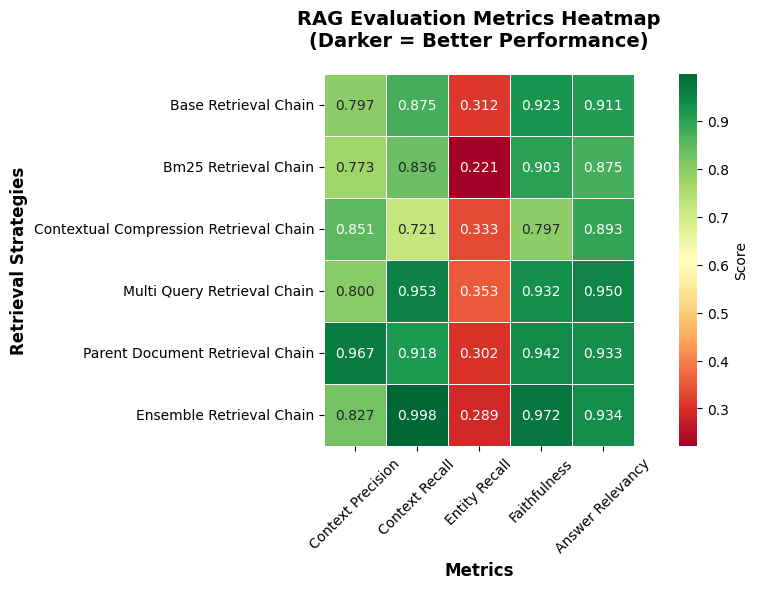

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create heatmap visualization with average scoring
def create_heatmap_visualization(eval_summary_results):
    """
    Create a heatmap showing metric performance across chains.
    Also computes average score and selects best retriever.
    """
    # Prepare data
    heatmap_data = []
    chains = list(eval_summary_results.keys())
    metrics = [
        'llm_context_precision_with_reference', 
        'context_recall', 
        'context_entity_recall', 
        'faithfulness', 
        'answer_relevancy'
    ]
    
    for chain in chains:
        means = eval_summary_results[chain]["means"]
        row_data = [means[metric] for metric in metrics]
        heatmap_data.append(row_data)
    
    # Create DataFrame for heatmap
    df_heatmap = pd.DataFrame(
        heatmap_data, 
        index=[chain.replace('_', ' ').title() for chain in chains],
        columns=['Context Precision', 'Context Recall', 'Entity Recall', 'Faithfulness', 'Answer Relevancy']
    )

    # Calculate average score for each retriever
    df_heatmap["Average Score"] = df_heatmap.mean(axis=1)

    # Identify best retriever
    best_retriever = df_heatmap["Average Score"].idxmax()
    best_score = df_heatmap["Average Score"].max()

    # Print metric scores per retriever
    print("\nMetric Scores per Retriever:")
    print(df_heatmap.round(3))

    print(f"\n🏆 Best Retriever: **{best_retriever}** with average score: **{best_score:.3f}**\n")

    # Create the heatmap (excluding average column)
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_heatmap.drop(columns=["Average Score"]), 
                annot=True, 
                cmap='RdYlGn',
                fmt='.3f',
                linewidths=0.5,
                cbar_kws={'label': 'Score'},
                square=True)

    plt.title('RAG Evaluation Metrics Heatmap\n(Darker = Better Performance)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Metrics', fontsize=12, fontweight='bold')
    plt.ylabel('Retrieval Strategies', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return df_heatmap


print("\nCreating heatmap visualization...")
heatmap_df = create_heatmap_visualization(eval_summary_results)

Costs and Latency

In [18]:
from langsmith import Client
from pprint import pprint

client = Client()

retrieval_names = [
              "naive_retrieval_chain",
              "bm25_retrieval_chain",
              "contextual_compression_retrieval_chain",
              "multi_query_retrieval_chain",
              "parent_document_retrieval_chain",
              "ensemble_retrieval_chain"]

cost_and_latency = {}
cost_and_latency_raw = {}
for retriever_name in retrieval_names:

    # Get latest runs
    runs = client.list_runs(
        project_name=langsmith_project_name,
        execution_order=1,
        order_by="start_time",
        limit=50,
        filter=f'eq(name, "RAG {retriever_name} - {MODE}")',
        order="desc"                         # Most recent first
    )

    latency_raw_list = []
    cost_raw_list = []
    for run in runs:
        if run.start_time and run.end_time:
            latency = (run.end_time - run.start_time).total_seconds()
            latency_raw_list.append(latency)
        if run.total_cost is not None:
            cost_raw_list.append(run.total_cost)

    cost_and_latency_raw[retriever_name] = {
        "cost_raw": cost_raw_list, 
        "latency_raw": latency_raw_list
    }

    cost_and_latency[retriever_name] = {
        "cost_total": np.array(cost_raw_list).sum(),
        "latency_mean": np.array(latency_raw_list).mean(),
        "latency_std": np.array(latency_raw_list).std()
    }

pprint(cost_and_latency)

/tmp/ipykernel_250689/2070942152.py:44: RuntimeWarning: Mean of empty slice.
  "latency_mean": np.array(latency_raw_list).mean(),
/home/jsmejia/the_ai_eng_bootcamp/code/aim_certification_challenge/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/jsmejia/the_ai_eng_bootcamp/code/aim_certification_challenge/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jsmejia/the_ai_eng_bootcamp/code/aim_certification_challenge/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/jsmejia/the_ai_eng_bootcamp/code/aim_certification_challenge/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:214: RuntimeWarning: invalid value enco

{'bm25_retrieval_chain': {'cost_total': Decimal('0.1969532'),
                          'latency_mean': np.float64(8.3328352),
                          'latency_std': np.float64(4.470733235766209)},
 'contextual_compression_retrieval_chain': {'cost_total': Decimal('0.0498272'),
                                            'latency_mean': np.float64(6.592974760000001),
                                            'latency_std': np.float64(4.877583368059365)},
 'ensemble_retrieval_chain': {'cost_total': Decimal('0.2670524'),
                              'latency_mean': np.float64(39.7797038),
                              'latency_std': np.float64(139.82569941352452)},
 'multi_query_retrieval_chain': {'cost_total': Decimal('0.1719156'),
                                 'latency_mean': np.float64(11.5150028),
                                 'latency_std': np.float64(3.9084445209830316)},
 'naive_retrieval_chain': {'cost_total': np.float64(0.0),
                           'latency_mean': 

Visualizations

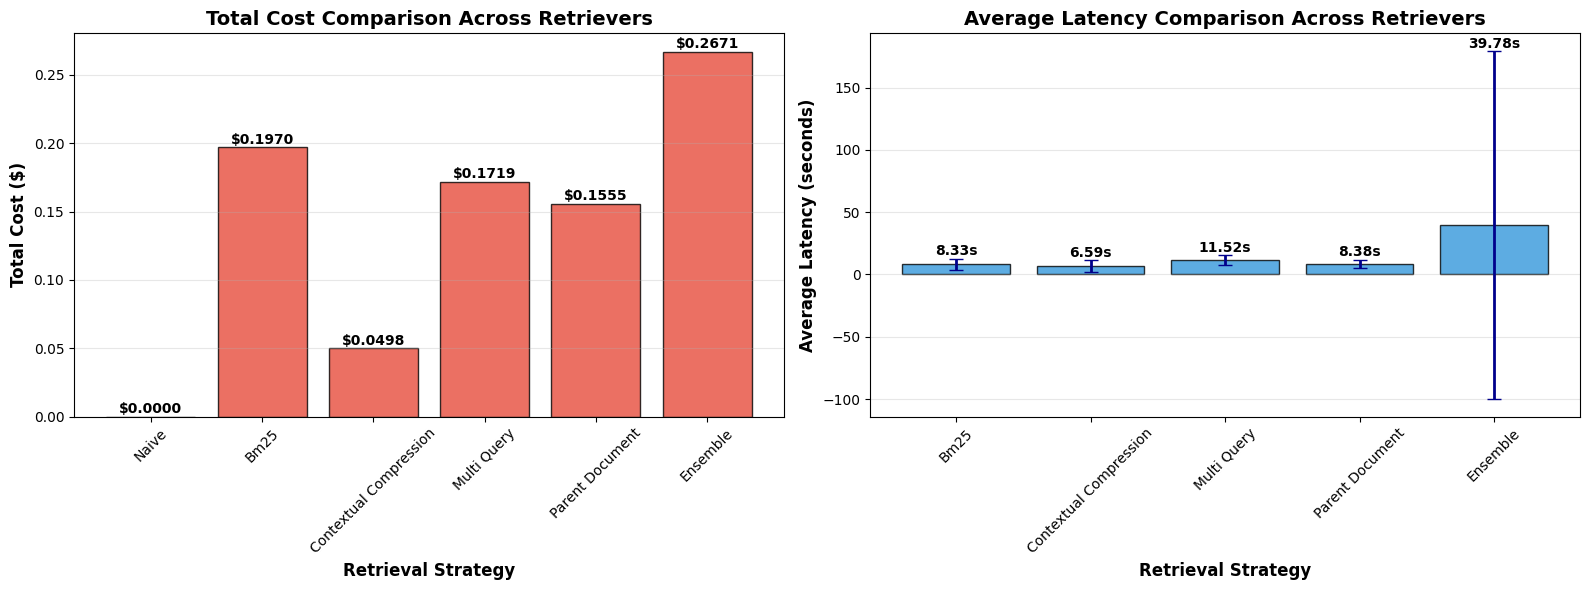


COST AND LATENCY SUMMARY

Naive:
  Total Cost: $0.0000
  Avg Latency: No data available

Bm25:
  Total Cost: $0.1970
  Avg Latency: 8.33 ± 4.47 seconds

Contextual Compression:
  Total Cost: $0.0498
  Avg Latency: 6.59 ± 4.88 seconds

Multi Query:
  Total Cost: $0.1719
  Avg Latency: 11.52 ± 3.91 seconds

Parent Document:
  Total Cost: $0.1555
  Avg Latency: 8.38 ± 3.53 seconds

Ensemble:
  Total Cost: $0.2671
  Avg Latency: 39.78 ± 139.83 seconds

🏆 Most Cost-Effective: Naive ($0.0000)
⚡ Fastest Response: Contextual Compression (6.59s)


In [19]:
# Create comparison plots for cost and latency
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
retrievers = list(cost_and_latency.keys())
costs = []
latencies = []
latency_stds = []

for retriever in retrievers:
    cost_total = float(cost_and_latency[retriever]['cost_total'])
    latency_mean = cost_and_latency[retriever]['latency_mean']
    latency_std = cost_and_latency[retriever]['latency_std']
    
    costs.append(cost_total)
    latencies.append(latency_mean)
    latency_stds.append(latency_std)

# Clean retriever names for display
clean_names = [name.replace('_retrieval_chain', '').replace('_', ' ').title() for name in retrievers]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cost Comparison
bars1 = ax1.bar(clean_names, costs, color='#E74C3C', alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('Total Cost Comparison Across Retrievers', fontsize=14, fontweight='bold')
ax1.set_xlabel('Retrieval Strategy', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Cost ($)', fontsize=12, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on cost bars
for bar, cost in zip(bars1, costs):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.0005,
             f'${cost:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Latency Comparison with error bars
# Filter out NaN values for plotting
valid_indices = [i for i, lat in enumerate(latencies) if not np.isnan(lat)]
valid_names = [clean_names[i] for i in valid_indices]
valid_latencies = [latencies[i] for i in valid_indices]
valid_stds = [latency_stds[i] for i in valid_indices]

bars2 = ax2.bar(valid_names, valid_latencies, yerr=valid_stds, 
                color='#3498DB', alpha=0.8, edgecolor='black', linewidth=1,
                capsize=5, error_kw={'linewidth': 2, 'ecolor': 'darkblue'})
ax2.set_title('Average Latency Comparison Across Retrievers', fontsize=14, fontweight='bold')
ax2.set_xlabel('Retrieval Strategy', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Latency (seconds)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

# Add value labels on latency bars
for bar, latency, std in zip(bars2, valid_latencies, valid_stds):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + std + 0.2,
             f'{latency:.2f}s', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("COST AND LATENCY SUMMARY")
print("="*60)
for i, retriever in enumerate(retrievers):
    print(f"\n{clean_names[i]}:")
    print(f"  Total Cost: ${costs[i]:.4f}")
    if not np.isnan(latencies[i]):
        print(f"  Avg Latency: {latencies[i]:.2f} ± {latency_stds[i]:.2f} seconds")
    else:
        print(f"  Avg Latency: No data available")

# Find best performers
if costs:
    min_cost_idx = costs.index(min(costs))
    print(f"\n🏆 Most Cost-Effective: {clean_names[min_cost_idx]} (${costs[min_cost_idx]:.4f})")

valid_latencies_with_names = [(lat, name) for lat, name in zip(valid_latencies, valid_names) if not np.isnan(lat)]
if valid_latencies_with_names:
    fastest_latency, fastest_name = min(valid_latencies_with_names)
    print(f"⚡ Fastest Response: {fastest_name} ({fastest_latency:.2f}s)")
